In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import argparse
import pickle
from tqdm import tqdm
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

In [2]:
class CTHMM:
    def __init__(self, n_states, n_dim):
        self.n_states = n_states
        self.log_pi = np.log(np.ones((self.n_states)) / self.n_states)
        self.log_P = {}
        self.n_pid = 0
        
        # init R
        self.R = -np.eye(self.n_states)
        self.R[-1, -1] = 0
        for i in range(self.n_states - 1):
            self.R[i,i+1:] = 1 / (self.R[i+1:].shape[0])
        
        self.n_dim = n_dim
        
        # init emission matrix
        self.emission_matrix = np.zeros((2, self.n_states, self.n_dim))
        self.emission_matrix[0, :, :] = 2
        self.emission_matrix[1, :, :] = .5
        self.emission_matrix[0, 0, :] = 4
        self.emission_matrix[0, -1, :] = 0

    def EM_step(self, data):
        ### E Step ###
        
        self.n_pid = data['subject_id'].unique().shape[0]
        
        log_pi_update = np.zeros((self.n_states))
        weighted_means = np.log(np.zeros((self.n_states, self.n_dim)))

        unique_intervals = data['delta_t'].unique()
        C = np.zeros((unique_intervals.shape[0], self.n_states, self.n_states))
        interval_map = {}
        
        total_weight_assgn = np.log(np.zeros((self.n_states)))
        
        for pid, pdata in data.groupby('subject_id'):
#             print (pdata.columns)
            obs = pdata.drop(['subject_id', 'ALSFRS_Delta', 'delta_t', 'ALSFRS_Total'], axis=1).values
            intervals = pdata['delta_t'].values

            alpha = self.forward(obs, intervals)
            beta = self.backward(obs, intervals)

            LL = logsumexp((alpha[:, -1] + beta[:, -1]))
            
#             print ('Sanity:\n', logsumexp((alpha + beta), axis=0))
            
            for idx, t_delta in enumerate(intervals[1:]):
                if t_delta not in interval_map:
                    interval_map[t_delta] = len(interval_map.keys())
                log_P = self.log_transition_matrix(t_delta)
                log_emission = self.log_emission(obs[idx + 1, :])
                for src in range(self.n_states):
                    for dest in range(self.n_states):
                        C[interval_map[t_delta], src, dest] = logsumexp([C[interval_map[t_delta], src, dest], alpha[src, idx], log_P[src, dest],
                                                                     beta[dest, idx + 1], log_emission[dest]])

            log_pi_update = logsumexp([log_pi_update, alpha[:, 0] + beta[:, 0] - LL], axis=0)
#             print ('alpha:\n', alpha)
#             print ('beta:\n', beta)
#             print ('LL:\n', LL)
#             print ('mean update:\n', np.e**(alpha + beta - LL) @ obs)
            log_weights = np.zeros(alpha.shape)
            for t in range(log_weights.shape[1]):
                log_weights[:,t] = alpha[:,t] + beta[:,t] - logsumexp(alpha[:,t] + beta[:,t])  # M x T
#             print ('Resp:\n', np.sum(np.exp(log_weights), axis=0))
#             print ('log_weights before:\n', log_weights)
#             print ('log_weights e sum:\n', np.sum(np.exp(log_weights), axis=1))
            for i in range(self.n_states):
                for t in range(log_weights.shape[1]):
                    for d in range(self.n_dim):
#                         print ('weighted_prev:\n', weighted_means[i,d])
#                         print ('obs:\n', obs[t,d])
#                         print ('adding:\n', log_weights[i,t] + np.log(obs[t,d]))
#                         print ('logsumexp:\n', logsumexp([weighted_means[i,d], log_weights[i,t] + np.log(obs[t,d])]))
                        weighted_means[i, d] = logsumexp([weighted_means[i,d], log_weights[i,t] + np.log(obs[t,d])])
                    total_weight_assgn[i] = logsumexp([total_weight_assgn[i], log_weights[i,t]])
#                     weighted_means[i, j] = np.e**(alpha + beta - LL) @ obs


        ### M Step ###

        # Update emission params
        self.emission_matrix[0, 1:-1, :] = np.e**(weighted_means - total_weight_assgn[:, None])[1:-1, :]
#         self.emission_matrix[0, 1:-1, :] = np.e**(weighted_means)[1:-1, :]
        print ('total_weight_assgn:\n', np.e**total_weight_assgn)

        # Update pi
        self.log_pi = log_pi_update - logsumexp(log_pi_update)

        # Updated R
        A = np.zeros((self.n_states * 2, self.n_states * 2))
        A[:self.n_states, :self.n_states] = self.R
        A[self.n_states:, self.n_states:] = self.R

        D = np.zeros((self.n_states, self.n_states, self.n_states))
        tau = np.zeros((self.n_states))

        N = np.zeros((self.n_states, self.n_states, self.n_states, self.n_states))
        nu = np.zeros((self.n_states, self.n_states))
        
        C = np.e**(C) - 1
        
#         print('past groupby')
#         print (interval_map)
        for i in range(self.n_states):
            A[i, self.n_states + i] = 1
            for t_delta in unique_intervals:
                if t_delta == 0:
                    continue
#                 print ('A exp:\n', la.expm(A * t_delta)[:self.n_states, self.n_states:])
#                 print ('e trans:\n',np.e**(self.log_transition_matrix(t_delta)))
#                 exit(0)
                D[i] = la.expm(A * t_delta)[:self.n_states, self.n_states:] /                           \
                       np.e**(self.log_transition_matrix(t_delta))
                D = np.nan_to_num(D)
                tau[i] += np.sum(C[interval_map[t_delta], :, :] * D[i, :, :])
            A[i, self.n_states + i] = 0

        for i in range(self.n_states):
            for j in range(self.n_states):
                A[i, self.n_states + j] = 1
                for t_delta in unique_intervals:
                    if t_delta == 0:
                        continue
                    N[i, j] = self.R[i, j] * la.expm(A * t_delta)[:self.n_states, self.n_states:] /        \
                           np.e**(self.log_transition_matrix(t_delta))
                    N = np.nan_to_num(N)
                    nu[i, j] += np.sum(C[interval_map[t_delta], :, :] * N[i, j, :, :])
                A[i, self.n_states + j] = 0
#         print ('C:\n', C)
#         print ('D:\n', D)
#         print('nu:\n',nu)
#         print ('tau:\n',tau)
        
        for i in range(self.n_states):
            self.R[i, i+1:] = nu[i, i+1:] / tau[i]
            self.R[i, i] = -np.sum(self.R[i, i+1:])
            
        self.log_P = {}


    def log_transition_matrix(self, t_delta):
        """
        Input:
            t_delta scalar
        Output:
            P M x M
        """
        if t_delta in self.log_P:
            return self.log_P[t_delta]
        
        self.log_P[t_delta] = np.log(la.expm(self.R * t_delta))
        
#         print('nonlog transition:\n', la.expm(self.R * t_delta))
#         print('log transition:\n', self.log_P[t_delta])
#         print('back to nonlog:\n', np.sum(np.e**(self.log_P[t_delta]), axis=1))

        return self.log_P[t_delta]

    def log_emission(self, observation):
        """
            Input: D x 1
            Output: M x 1
        """
        b = np.ndarray(self.n_states, dtype=float)
        for i in range(self.n_states):
            means = self.emission_matrix[0, i]
            covariance = np.diag(self.emission_matrix[1, i])
            b[i] = multivariate_normal.logpdf(observation, means, covariance)
        return b

    def forward(self, obs, intervals):
        """
        Input:
            obs T x D
            intervals T
            n_states scalar
        Output:
            alpha M x T
        """
        T = obs.shape[0]

        alpha = np.zeros((self.n_states, T))

#         print ('pi:\n', self.log_pi)
#         print ('emission:\n', self.log_emission(obs[0,:]))
        alpha[:, 0] = self.log_pi + self.log_emission(obs[0, :])
        
#         print('alpha t=0:\n', alpha[:,0])

        tmp = np.zeros((self.n_states))

        for idx, t_delta in enumerate(intervals[1:]):
            log_B = self.log_emission(obs[idx + 1, :])
            log_P = self.log_transition_matrix(t_delta)
            
#             print ('transition:\n', log_P)

            for dest in range(self.n_states):
                for src in range(self.n_states):
                    tmp[src] = alpha[src, idx] + log_P[src, dest]

                alpha[dest, idx + 1] = log_B[dest] + logsumexp(tmp)

#         print ('alpha:\n', alpha)
        return alpha

    def backward(self, observations, time_intervals):
        T = observations.shape[0]
        beta = np.zeros((self.n_states, T), dtype=float)
        for t in range(T - 2, -1, -1):
            a = self.log_transition_matrix(time_intervals[t])
            b = self.log_emission(observations[t + 1])
            for i in range(self.n_states):
                beta[i, t] = logsumexp([beta[j, t + 1] + a[i, j] + b[j] for j in range(self.n_states)])

#         print ('beta:\n', beta)
        return beta

    def update_pi(self, alpha, beta):
        self.log_pi = alpha[0, :] + beta[0, :]
    def log_likelihood(self, data):
        total = 0
        for pid, pdata in data.groupby('subject_id'):
            obs = pdata.drop(['subject_id', 'ALSFRS_Delta', 'delta_t', 'ALSFRS_Total'], axis=1).values
            intervals = pdata['delta_t'].values

            alpha = self.forward(obs, intervals)
            total += logsumexp(alpha[-1])

        return total

    def save(self, filename):
        pickle.dump(self, open(filename, 'wb'))

    @classmethod
    def load(cls, filename):
        return pickle.load(open(filename, 'rb'))

In [3]:
model = pickle.load(open('big_model.pickle', 'rb'))

In [4]:
model

In [5]:
pd.DataFrame(np.exp(model.log_pi))

,0
0,0.235609
1,0.194847
2,0.389039
3,0.026329
4,0.021878
5,0.103730
6,0.008692
7,0.010749
8,0.006890
9,0.001281


In [14]:
pd.DataFrame(np.around(la.expm(model.R), decimals=2))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.96,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.97,0.01,0.01,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.97,0.01,0.01,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.97,0.01,0.01,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.01,0.01,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.01,0.01,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.01,0.00


In [13]:
pd.DataFrame(np.around(la.expm(model.R * 120), decimals=2))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.01,0.02,0.02,0.03,0.04,0.06,0.08,0.10,0.14,0.19,0.30
1,0.0,0.01,0.01,0.02,0.03,0.04,0.06,0.08,0.10,0.14,0.20,0.30
2,0.0,0.00,0.01,0.02,0.03,0.04,0.06,0.08,0.11,0.14,0.20,0.31
3,0.0,0.00,0.00,0.01,0.03,0.04,0.06,0.08,0.11,0.15,0.21,0.32
4,0.0,0.00,0.00,0.00,0.02,0.04,0.05,0.08,0.11,0.15,0.22,0.34
5,0.0,0.00,0.00,0.00,0.00,0.03,0.05,0.08,0.11,0.16,0.23,0.36
6,0.0,0.00,0.00,0.00,0.00,0.00,0.04,0.07,0.11,0.16,0.24,0.39
7,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.10,0.16,0.25,0.42
8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.17,0.27,0.47
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.30,0.54


In [7]:
means = model.emission_matrix[0]
variance = model.emission_matrix[1]

In [8]:
pd.DataFrame(np.around(means, decimals=2))

,0,1,2,3,4,5,6,7,8,9
0,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
1,3.78,3.83,3.86,3.77,3.83,3.08,3.32,2.14,1.12,3.78
2,3.58,3.67,3.75,2.91,2.62,2.67,3.54,3.55,3.49,3.76
3,1.10,1.73,2.15,3.64,3.58,3.54,3.80,3.64,3.43,3.46
4,2.16,2.65,2.75,3.00,2.56,2.40,2.93,2.37,1.24,3.13
5,3.66,3.80,3.81,2.89,2.46,2.32,2.97,2.21,1.01,3.60
6,3.45,3.70,3.60,2.95,2.11,1.29,1.58,1.17,0.15,3.31
7,3.25,3.48,3.56,1.36,0.99,1.37,2.39,2.77,1.88,3.53
8,3.20,3.59,3.50,0.68,0.46,0.45,1.03,1.38,0.25,3.17
9,1.41,2.25,1.95,0.53,0.27,0.34,0.81,1.24,0.21,2.82


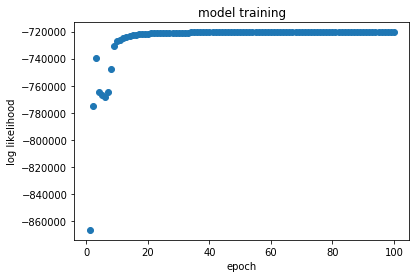

In [9]:
plt.scatter(range(1,101), model.log_likelihoods)
plt.xlabel('epoch')
plt.ylabel('log likelihood')
plt.title('model training')
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
def displaymeans(means):

    z = []
    z = means

    fig, ax = plt.subplots()
    im = ax.imshow(z)
    fig.colorbar(im)
    for i in range(len(z)):
        
        for j in range(len(z[1])):
            text = ax.text(j, i, round(z[i][j],1),
                           ha="center", va="center", color="w")

    ax.axis('tight')
    fig.tight_layout()
    plt.show(ax)

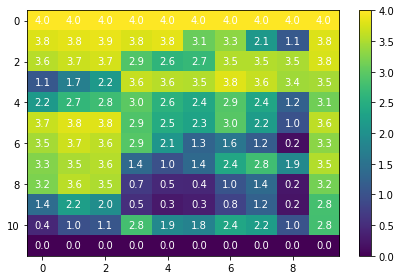

In [11]:
displaymeans(means)